# QUELLE ÉVOLUTION DE L'ACTIVITÉ CES 30 DERNIERS JOURS ?

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt,timedelta
from datetime import date
import seaborn as sns
from kiblib.utils.db import DbConn
from kiblib.utils import lucas_sns_params
import warnings
warnings.filterwarnings("ignore")

In [2]:
maj = dt.today().strftime('%d-%m-%Y à %Hh%M' )
print(f"Dernière mise à jour le {maj}")

Dernière mise à jour le 26-04-2024 à 13h51


In [3]:
db_conn = DbConn().create_engine()

In [4]:
annee = pd.to_datetime("today").year
semaine_max = pd.to_datetime("today").week
semaine_min = semaine_max - 5 
JourDeLaSemaine = "AS 'jour'"

In [5]:
x = date.today().isocalendar()[2]

In [6]:
fin_cal = date.today() - timedelta(days=x)

In [7]:
debut_cal = fin_cal - timedelta(days=27)

In [8]:
calendrier_index = pd.date_range(start=debut_cal, end=fin_cal)

In [9]:
calendrier = calendrier_index.to_frame(index=False, name='jour')

In [10]:
calendrier['jour'] = pd.DatetimeIndex(calendrier['jour']).date

In [11]:
query = f"SELECT datetime AS 'jour', entrees AS nombre_entrees FROM statdb.stat_entrees WHERE YEAR(`datetime`) = {annee}"

In [12]:
entrees = pd.read_sql(query,db_conn)

In [13]:
entrees['jour'] = pd.to_datetime(entrees['jour'],errors='coerce')
#entrees['semaine'] = pd.DatetimeIndex(entrees['jour']).week
entrees['semaine'] = entrees['jour'].dt.isocalendar().week
entrees["jour"] = pd.DatetimeIndex(entrees["jour"]).date

In [14]:
entrees_4lastweek = entrees[entrees["semaine"].between(semaine_min,semaine_max)]

In [15]:
entrees_4lastweek = entrees_4lastweek.groupby("jour")["nombre_entrees"].sum()

In [16]:
entrees_4lastweek = entrees_4lastweek.reset_index()

In [17]:
entrees_4lastweek = entrees_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')

In [18]:
entrees_4lastweek['jour'] = pd.to_datetime(entrees_4lastweek['jour'],errors='coerce')
entrees_4lastweek["jour_str"] = pd.DatetimeIndex(entrees_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
entrees_4lastweek["jour_num"] = pd.DatetimeIndex(entrees_4lastweek["jour"]).day
entrees_4lastweek["mois"] = pd.DatetimeIndex(entrees_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
entrees_4lastweek["jour"] = pd.DatetimeIndex(entrees_4lastweek["jour"]).date

In [37]:
#entrees_4lastweek["date"] = entrees_4lastweek["jour_str"] + ' ' + entrees_4lastweek["jour_num"].astype(str) + ' ' + entrees_4lastweek["mois"]

pd.to_datetime(entrees_4lastweek['jour']).dt.strftime('%A %d %B %Y')

0         lundi 25 mars 2024
1         mardi 26 mars 2024
2      mercredi 27 mars 2024
3         jeudi 28 mars 2024
4      vendredi 29 mars 2024
5        samedi 30 mars 2024
6      dimanche 31 mars 2024
7        lundi 01 avril 2024
8        mardi 02 avril 2024
9     mercredi 03 avril 2024
10       jeudi 04 avril 2024
11    vendredi 05 avril 2024
12      samedi 06 avril 2024
13    dimanche 07 avril 2024
14       lundi 08 avril 2024
15       mardi 09 avril 2024
16    mercredi 10 avril 2024
17       jeudi 11 avril 2024
18    vendredi 12 avril 2024
19      samedi 13 avril 2024
20    dimanche 14 avril 2024
21       lundi 15 avril 2024
22       mardi 16 avril 2024
23    mercredi 17 avril 2024
24       jeudi 18 avril 2024
25    vendredi 19 avril 2024
26      samedi 20 avril 2024
27    dimanche 21 avril 2024
Name: jour, dtype: object

In [20]:
entrees_4lastweek.loc[entrees_4lastweek['nombre_entrees']>0,['jour ouvert']] = 1
entrees_4lastweek.loc[(entrees_4lastweek["jour_str"]=="Dimanche") & 
                      (entrees_4lastweek["nombre_entrees"]>0),["jour ouvert"]] = entrees_4lastweek["jour ouvert"]-0.5

In [21]:
nb_jours_ouverts = entrees_4lastweek['jour ouvert'].sum()

In [22]:
total_entrees = entrees_4lastweek["nombre_entrees"].sum().astype(int)

In [23]:
mean_entrees = (total_entrees / nb_jours_ouverts).round(0).astype(int)

In [1]:
ax = sns.barplot(data=entrees_4lastweek,x='date',y='nombre_entrees',color='mediumaquamarine')
ax.set_title("Nombre d'entrées ces 4 dernières semaines")
ax.set_ylabel("Nombre d'entrées")
ax.tick_params(axis='x',rotation=80,bottom=True)
ax.axhline(y=mean_entrees)
for i in ax.containers:
    ax.bar_label(i,)

NameError: name 'sns' is not defined

In [26]:
query = f"SELECT heure_deb AS 'jour',borrowernumber FROM statdb.stat_webkiosk WHERE YEAR(heure_deb) = {annee}"

In [27]:
ordis = pd.read_sql(query,db_conn)

In [28]:
ordis['jour'] = pd.to_datetime(ordis['jour'])
ordis['nombre_connexions'] = 1
#ordis['semaine'] = pd.DatetimeIndex(ordis['jour']).week
ordis['semaine'] = ordis['jour'].dt.isocalendar().week
ordis['jour'] = pd.DatetimeIndex(ordis['jour']).date

In [29]:
ordis_4lastweek = ordis[ordis["semaine"].between(semaine_min,semaine_max)]

In [30]:
ordis_4lastweek = ordis_4lastweek.groupby("jour")["nombre_connexions"].sum()

In [31]:
ordis_4lastweek = ordis_4lastweek.reset_index()
ordis_4lastweek['type'] = 'ordinateur'
ordis_4lastweek = ordis_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')

In [32]:
ordis_4lastweek["jour"] = pd.DatetimeIndex(ordis_4lastweek["jour"])
ordis_4lastweek["jour_str"] = pd.DatetimeIndex(ordis_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
ordis_4lastweek["jour_num"] = pd.DatetimeIndex(ordis_4lastweek["jour"]).day
ordis_4lastweek["mois"] = pd.DatetimeIndex(ordis_4lastweek["jour"]).month_name(locale='fr_FR.utf8')

ordis_4lastweek["date"] = ordis_4lastweek["jour_str"] + ' ' + ordis_4lastweek["jour_num"].astype(str) + ' ' + ordis_4lastweek["mois"]

In [33]:
ordis_4lastweek.loc[ordis_4lastweek['nombre_connexions']>0,['jour ouvert']] = 1
ordis_4lastweek.loc[(ordis_4lastweek['jour_str']=='Dimanche') &
                   (ordis_4lastweek['nombre_connexions']>0),['jour ouvert']] = ordis_4lastweek['jour ouvert']-0.5

In [34]:
nb_jours_ouverts = ordis_4lastweek['jour ouvert'].sum()

In [35]:
total_ordis = ordis_4lastweek["nombre_connexions"].sum().astype(int)

In [36]:
mean_ordis = (total_ordis/nb_jours_ouverts).round(0).astype(int)

In [37]:
query = f"SELECT heure_deb AS 'jour',borrowernumber FROM statdb.stat_webkiosk WHERE YEAR(heure_deb) = {annee}"

In [38]:
distinct_ordis = pd.read_sql(query,db_conn)

In [39]:
distinct_ordis['jour'] = pd.to_datetime(distinct_ordis['jour'])
distinct_ordis['nombre_connexions'] = 1
#distinct_ordis['semaine'] = pd.DatetimeIndex(distinct_ordis['jour']).week
distinct_ordis['semaine'] = distinct_ordis['jour'].dt.isocalendar().week
distinct_ordis['jour'] = pd.DatetimeIndex(distinct_ordis['jour']).date

In [40]:
distinct_ordis = distinct_ordis[distinct_ordis["semaine"].between(semaine_min,semaine_max)]

In [41]:
distinct_ordis = distinct_ordis.groupby("nombre_connexions")["borrowernumber"].nunique().sum()

In [42]:
ordis_4lastweek["type"] = 'ordinateurs'

In [43]:
query = f"SELECT start_wifi AS 'jour'FROM statdb.stat_wifi WHERE YEAR(start_wifi) = {annee}"

In [44]:
wifi = pd.read_sql(query,db_conn)

In [45]:
wifi['jour'] = pd.to_datetime(wifi['jour'])
wifi["nombre_connexions"] = 1
#wifi['semaine'] = pd.DatetimeIndex(wifi['jour']).week
wifi['semaine'] = wifi['jour'].dt.isocalendar().week
wifi['jour'] = pd.DatetimeIndex(wifi['jour']).date

In [46]:
wifi_4lastweek = wifi[wifi["semaine"].between(semaine_min,semaine_max)]

In [47]:
wifi_4lastweek = wifi_4lastweek.groupby("jour")["nombre_connexions"].sum()

In [48]:
wifi_4lastweek = wifi_4lastweek.reset_index()
wifi_4lastweek["type"] = "wifi"

In [49]:
wifi_4lastweek = wifi_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')

In [50]:
wifi_4lastweek["jour"] = pd.DatetimeIndex(wifi_4lastweek["jour"])
wifi_4lastweek["jour_str"] = pd.DatetimeIndex(wifi_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
wifi_4lastweek["jour_num"] = pd.DatetimeIndex(wifi_4lastweek["jour"]).day
wifi_4lastweek["mois"] = pd.DatetimeIndex(wifi_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
wifi_4lastweek["date"] = wifi_4lastweek["jour_str"] + ' ' + wifi_4lastweek["jour_num"].astype(str) + ' ' + wifi_4lastweek["mois"]

In [51]:
wifi_4lastweek.loc[wifi_4lastweek['nombre_connexions']>0,['jour ouvert']] = 1
wifi_4lastweek.loc[(wifi_4lastweek["jour_str"]=="Dimanche") & 
                      (wifi_4lastweek["nombre_connexions"]>0),["jour ouvert"]] = wifi_4lastweek["jour ouvert"]-0.5
nb_jours_ouverts = wifi_4lastweek['jour ouvert'].sum()

In [52]:
total_wifi = wifi_4lastweek["nombre_connexions"].sum().astype(int)

In [53]:
mean_wifi = (total_wifi/nb_jours_ouverts).round(0).astype(int)

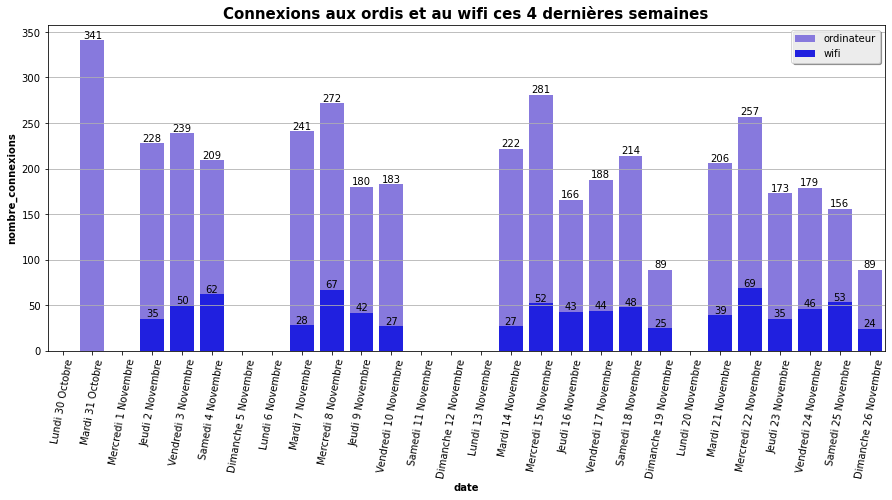

In [54]:
ax = sns.barplot(data=ordis_4lastweek,x="date",y='nombre_connexions',color='mediumslateblue',label="ordinateur")
sns.barplot(data=wifi_4lastweek,x="date",y='nombre_connexions',ax=ax,color='blue',label="wifi")
ax.set_title("Connexions aux ordis et au wifi ces 4 dernières semaines")
ax.tick_params(axis='x',rotation=80)                   
plt.legend()
for i in ax.containers:
    ax.bar_label(i,)

In [55]:
query = f"SELECT start_wifi AS 'jour',borrowernumber FROM statdb.stat_wifi WHERE YEAR(start_wifi) = {annee}"

In [56]:
distinct_wifi = pd.read_sql(query,db_conn)

In [57]:
distinct_wifi['jour'] = pd.to_datetime(distinct_wifi['jour'])
distinct_wifi['nombre_connexions'] = 1
#distinct_wifi['semaine'] = pd.DatetimeIndex(distinct_wifi['jour']).week
distinct_wifi['semaine'] = distinct_wifi['jour'].dt.isocalendar().week
distinct_wifi['jour'] = pd.DatetimeIndex(distinct_wifi['jour']).date

In [58]:
distinct_wifi = distinct_wifi[distinct_wifi["semaine"].between(semaine_min,semaine_max)]

In [59]:
distinct_wifi = distinct_wifi.groupby("nombre_connexions")["borrowernumber"].nunique().sum()

In [60]:
query = f"SELECT pret_date_pret AS 'jour' FROM statdb.stat_prets sp WHERE YEAR(pret_date_pret) ={annee}"

In [61]:
prets = pd.read_sql(query,db_conn)

In [62]:
prets['jour'] = pd.to_datetime(prets['jour'])
prets["nombre_emprunts"] = 1
#prets["semaine"] = pd.DatetimeIndex(prets["jour"]).week
prets['semaine'] = prets['jour'].dt.isocalendar().week
prets['jour'] = prets['jour'].dt.date

In [63]:
prets_4lastweek = prets[prets['semaine'].between(semaine_min,semaine_max)]

In [64]:
prets_4lastweek = prets_4lastweek.groupby("jour")["nombre_emprunts"].sum()

In [65]:
prets_4lastweek = prets_4lastweek.reset_index()

In [66]:
prets_4lastweek = prets_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')

In [67]:
prets_4lastweek["jour"] = pd.DatetimeIndex(prets_4lastweek["jour"])
prets_4lastweek["jour_str"] = pd.DatetimeIndex(prets_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
prets_4lastweek["jour_num"] = pd.DatetimeIndex(prets_4lastweek["jour"]).day
prets_4lastweek["mois"] = pd.DatetimeIndex(prets_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
prets_4lastweek["date"] = prets_4lastweek["jour_str"] + ' ' + prets_4lastweek["jour_num"].astype(str) + ' ' + prets_4lastweek["mois"]

In [68]:
prets_4lastweek.loc[prets_4lastweek['nombre_emprunts']>0,['jour ouvert']] = 1
prets_4lastweek.loc[(prets_4lastweek['jour_str']=='Dimanche')&
                   (prets_4lastweek['nombre_emprunts']>0),['jour ouvert']] = prets_4lastweek['jour ouvert']-0.5
nb_jours_ouverts = prets_4lastweek['jour ouvert'].sum()

In [69]:
total_prets = prets_4lastweek["nombre_emprunts"].sum().astype(int)

In [70]:
mean_prets = (total_prets/nb_jours_ouverts).round(0).astype(int)

In [71]:
query = f"SELECT issuedate AS 'jour',borrowernumber FROM statdb.stat_issues si WHERE YEAR(issuedate) = {annee}"

In [72]:
distinct_prets = pd.read_sql(query,db_conn)

In [73]:
distinct_prets['jour'] =pd.to_datetime(distinct_prets['jour'])
distinct_prets['nombre_prets'] = 1
#distinct_prets['semaine'] = pd.DatetimeIndex(distinct_prets['jour']).week
distinct_prets['semaine'] = distinct_prets['jour'].dt.isocalendar().week
distinct_prets['jour'] = pd.DatetimeIndex(distinct_prets['jour']).date

In [74]:
distinct_prets = distinct_prets[distinct_prets["semaine"].between(semaine_min,semaine_max)]

In [75]:
distinct_prets = distinct_prets.groupby("nombre_prets")["borrowernumber"].nunique().sum()

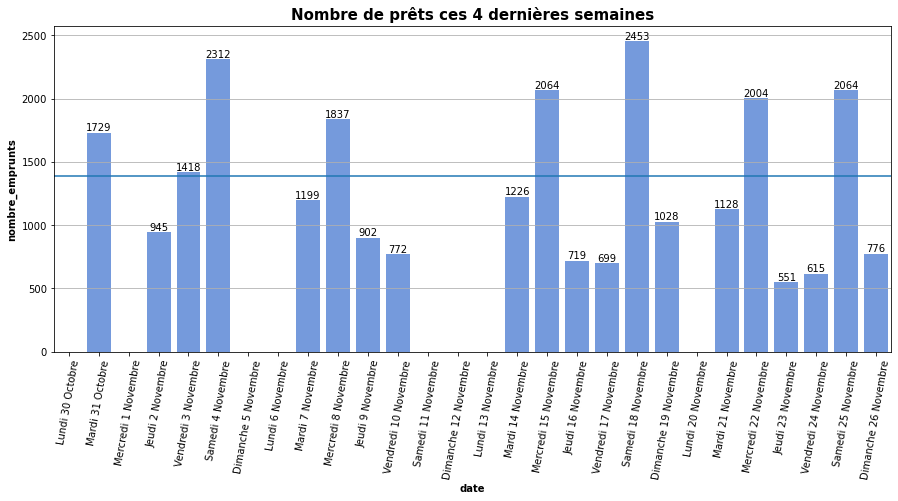

In [76]:
ax = sns.barplot(data=prets_4lastweek,x='date',y='nombre_emprunts',label='prets',color='cornflowerblue')
ax.set_title('Nombre de prêts ces 4 dernières semaines')
ax.tick_params(axis='x',rotation=80)
ax.axhline(y=mean_prets)
for i in ax.containers:
    ax.bar_label(i,)

In [77]:
query = f"SELECT pret_date_retour_effectif AS 'jour' FROM statdb.stat_prets sp WHERE YEAR(pret_date_pret) = {annee}"

In [78]:
retours = pd.read_sql(query,db_conn)

In [79]:
retours['jour'] = pd.to_datetime(retours['jour'])
retours["nombre_retours"] = 1
#retours["semaine"] = pd.DatetimeIndex(retours["jour"]).week
retours['semaine'] = retours['jour'].dt.isocalendar().week
retours['jour'] = retours['jour'].dt.date

In [80]:
retours = retours[retours["semaine"].between(semaine_min,semaine_max)]

In [81]:
retours_4lastweek = retours.groupby("jour")["nombre_retours"].sum()
retours_4lastweek = retours_4lastweek.reset_index()

In [82]:
retours_4lastweek = retours_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')

In [83]:
retours_4lastweek["jour"] = pd.DatetimeIndex(retours_4lastweek["jour"])
retours_4lastweek["jour_str"] = pd.DatetimeIndex(retours_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
retours_4lastweek["jour_num"] = pd.DatetimeIndex(retours_4lastweek["jour"]).day
retours_4lastweek["mois"] = pd.DatetimeIndex(retours_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
retours_4lastweek["date"] = retours_4lastweek["jour_str"] + ' ' + retours_4lastweek["jour_num"].astype(str) + ' ' + retours_4lastweek["mois"]

In [84]:
retours_4lastweek.loc[retours_4lastweek["nombre_retours"]>0,["jour ouvert"]] = 1
retours_4lastweek.loc[(retours_4lastweek["jour_str"]=="Dimanche") & 
                      (retours_4lastweek["nombre_retours"]>0),["jour ouvert"]] = retours_4lastweek["jour ouvert"]-0.5

In [85]:
nb_jours_ouverts = retours_4lastweek["jour ouvert"].sum()

In [86]:
total_retours = retours_4lastweek["nombre_retours"].sum().astype(int)

In [87]:
mean_retours = (total_retours / nb_jours_ouverts).round(0).astype(int)

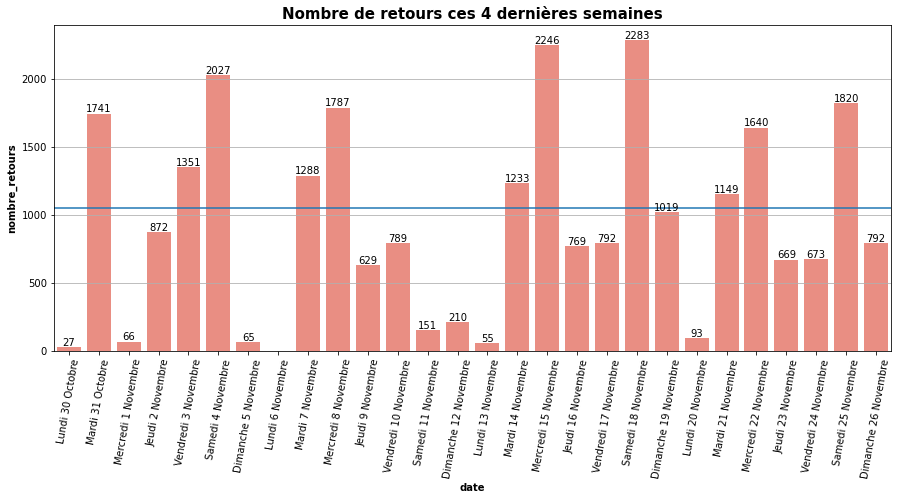

In [88]:
ax = sns.barplot(data=retours_4lastweek,x='date',y='nombre_retours',label='retours',color='salmon')
ax.set_title('Nombre de retours ces 4 dernières semaines')
ax.tick_params(axis='x',rotation=80)
ax.axhline(y=mean_retours,label='Moyenne')
for i in ax.containers:
    ax.bar_label(i,)

In [89]:
query = f"SELECT reservedate AS 'jour' FROM statdb.stat_reserves sr WHERE YEAR(reservedate) = {annee}"

In [90]:
reservations = pd.read_sql(query,db_conn)

In [91]:
reservations['jour']= pd.to_datetime(reservations['jour'])
reservations['nombre_reservations'] = 1
#reservations['semaine'] = pd.DatetimeIndex(reservations['jour']).week
reservations['semaine'] = reservations['jour'].dt.isocalendar().week
reservations['jour'] = pd.DatetimeIndex(reservations['jour']).date

In [92]:
reservations_4lastweek = reservations[reservations["semaine"].between(semaine_min,semaine_max)]

In [93]:
reservations_4lastweek = reservations_4lastweek.groupby("jour")["nombre_reservations"].sum()
reservations_4lastweek = reservations_4lastweek.reset_index()

In [94]:
reservations_4lastweek = reservations_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')

In [95]:
reservations_4lastweek["jour"] = pd.DatetimeIndex(reservations_4lastweek["jour"])
reservations_4lastweek["jour_str"] = pd.DatetimeIndex(reservations_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
reservations_4lastweek["jour_num"] = pd.DatetimeIndex(reservations_4lastweek["jour"]).day
reservations_4lastweek["mois"] = pd.DatetimeIndex(reservations_4lastweek["jour"]).month_name(locale='fr_FR.utf8')

reservations_4lastweek["date"] = reservations_4lastweek["jour_str"] + ' ' + reservations_4lastweek["jour_num"].astype(str) + ' ' + reservations_4lastweek["mois"]

In [96]:
reservations_4lastweek['jour ouvert'] = 1

nb_jours_ouverts = reservations_4lastweek['jour ouvert'].sum()

In [97]:
total_reservations = reservations_4lastweek["nombre_reservations"].sum().astype(int)

In [98]:
mean_reservations = (total_reservations/nb_jours_ouverts).round(0).astype(int)

In [99]:
query = f"SELECT reservedate AS 'jour',borrowernumber FROM statdb.stat_reserves sr WHERE YEAR(reservedate) = {annee}"

In [100]:
distinct_resas = pd.read_sql(query,db_conn)

In [101]:
distinct_resas['jour'] = pd.to_datetime(distinct_resas['jour'])
distinct_resas['nombre_resas'] = 1
#distinct_resas['semaine'] = pd.DatetimeIndex(distinct_resas['jour']).week
distinct_resas['semaine'] = distinct_resas['jour'].dt.isocalendar().week
distinct_resas['jour'] = pd.DatetimeIndex(distinct_resas['jour']).date

In [102]:
distinct_resas = distinct_resas[distinct_resas["semaine"].between(semaine_min,semaine_max)]
distinct_resas = distinct_resas.groupby("nombre_resas")["borrowernumber"].nunique().sum()

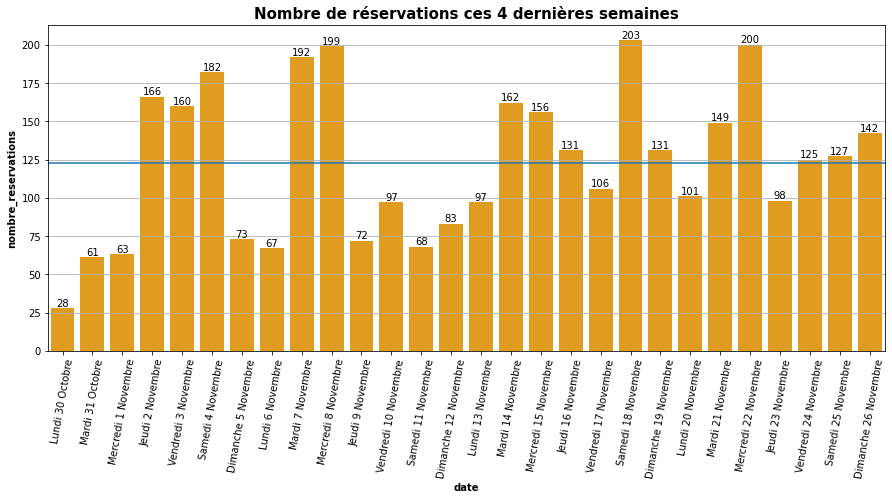

In [103]:
ax = sns.barplot(data=reservations_4lastweek,x='date',y='nombre_reservations',color='orange')
ax.set_title("Nombre de réservations ces 4 dernières semaines")
ax.tick_params(axis='x',rotation=80)
ax.axhline(y=mean_reservations)
for i in ax.containers:
    ax.bar_label(i,)

In [104]:
query = f"SELECT datetime_entree AS jour FROM statdb.stat_freq_etude sfe WHERE YEAR(datetime_entree) = {annee}"

In [105]:
visites = pd.read_sql(query,db_conn)

In [106]:
visites['jour'] = pd.to_datetime(visites['jour'])
visites["nombre_visites"] = 1
#visites["semaine"] = pd.DatetimeIndex(visites["jour"]).week
visites['semaine'] = visites['jour'].dt.isocalendar().week
visites["jour"] = pd.DatetimeIndex(visites["jour"]).date

In [107]:
visites_4lastweek = visites[visites["semaine"].between(semaine_min,semaine_max)]

In [108]:
visites_4lastweek = visites_4lastweek.groupby("jour")["nombre_visites"].sum()

In [109]:
visites_4lastweek = visites_4lastweek.reset_index()

In [110]:
visites_4lastweek = visites_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')

In [111]:
visites_4lastweek["jour"] = pd.DatetimeIndex(visites_4lastweek["jour"])
visites_4lastweek["jour_str"] = pd.DatetimeIndex(visites_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
visites_4lastweek["jour_num"] = pd.DatetimeIndex(visites_4lastweek["jour"]).day
visites_4lastweek["mois"] = pd.DatetimeIndex(visites_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
visites_4lastweek["date"] = visites_4lastweek["jour_str"] + ' ' + visites_4lastweek["jour_num"].astype(str) + ' ' + visites_4lastweek["mois"]

In [112]:
visites_4lastweek.loc[visites_4lastweek['nombre_visites']>0,['jour ouvert']] = 1
visites_4lastweek.loc[(visites_4lastweek['jour_str']=='Dimanche')&
                     (visites_4lastweek['nombre_visites']>0),['jour ouvert']] = visites_4lastweek['jour ouvert']-0.5

In [113]:
nb_jours_ouverts = visites_4lastweek['jour ouvert'].sum()

In [114]:
total_visites = visites_4lastweek["nombre_visites"].sum().astype(int)

In [115]:
mean_visites = (total_visites/nb_jours_ouverts).round(0).astype(int)

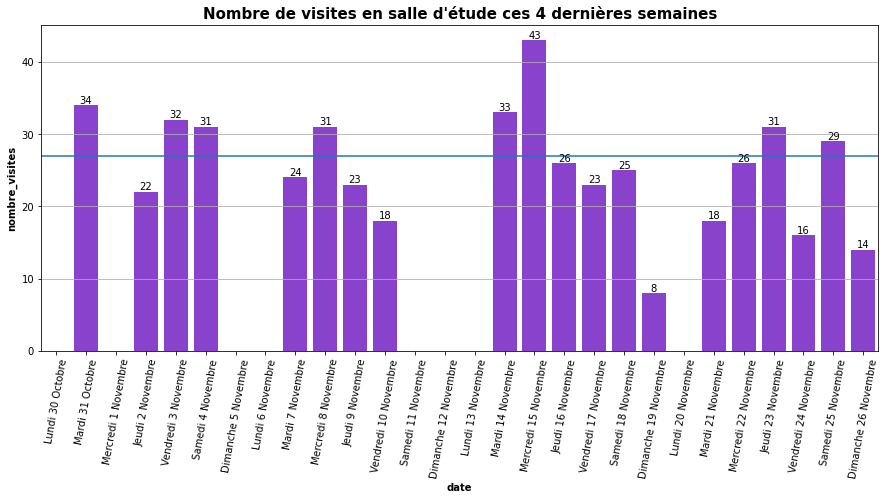

In [116]:
ax = sns.barplot(data=visites_4lastweek,x='date',y='nombre_visites',color='blueviolet')
ax.set_title("Nombre de visites en salle d'étude ces 4 dernières semaines")
ax.tick_params(axis='x',rotation=80)
ax.axhline(y=mean_visites)
for i in ax.containers:
    ax.bar_label(i,)

# Chiffres sur les 4 dernières semaines

In [117]:
print(f"{total_entrees} entrées avec en moyenne {mean_entrees} entrées par jour")
print(f"{total_ordis} connexions aux ordinateurs pour {distinct_ordis} utilisateurs distincts avec en moyenne {mean_ordis} connexions par jour")
print(f"{total_wifi} connexions au wifi pour {distinct_wifi} utilisateurs distincts avec en moyenne {mean_wifi} connexions par jour")
print(f"{total_prets} prêts pour {distinct_prets} emprunteur.ses distinct.es avec en moyenne {mean_prets} prets par jour")
print(f"{total_retours} retours avec en moyenne {mean_retours} retours par jour")
print(f"{total_reservations} réservations pour {distinct_resas} réserveur.ses avec en moyenne {mean_reservations} réservations par jour")
print(f"{total_visites} visites en salle d'étude avec en moyenne {mean_visites} visites par jour")

19025 entrées avec en moyenne 1001 entrées par jour
4113 connexions aux ordinateurs pour 1475 utilisateurs distincts avec en moyenne 216 connexions par jour
816 connexions au wifi pour 339 utilisateurs distincts avec en moyenne 45 connexions par jour
26441 prêts pour 4117 emprunteur.ses distinct.es avec en moyenne 1392 prets par jour
26236 retours avec en moyenne 1049 retours par jour
3439 réservations pour 1033 réserveur.ses avec en moyenne 123 réservations par jour
507 visites en salle d'étude avec en moyenne 27 visites par jour


In [119]:
# On définit une variable année
#annee = 2023
#
#vacances = pd.read_csv("/home/kibini/kibini2/data_lucas/vacances.csv")
#vacances

#vacances['annee'] = pd.DatetimeIndex(vacances['date']).year
#vacances['semaine'] = pd.DatetimeIndex(vacances['date']).week
#vacances['jour'] = pd.DatetimeIndex(vacances['date']).date

#vacances_thisyear = vacances[vacances['annee'] ==annee]
#vacances_thisyear = vacances_thisyear[vacances_thisyear['vacances_zone_b']==True]